<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
from tensorflow.keras import preprocessing
import numpy as np
from keras.utils.data_utils import pad_sequences
from keras.preprocessing.text import Tokenizer

import pandas as pd
import matplotlib.pyplot as plt 
from googletrans import Translator

## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [79]:
reviews=pd.read_csv("whatsapp_reviews.csv")

In [80]:
reviews.count()

reviewId                253200
userName                253200
userImage               253200
content                 253186
score                   253200
thumbsUpCount           253200
reviewCreatedVersion    198097
at                      253200
replyContent                 0
repliedAt                    0
dtype: int64

### 1.2 Data Processing


Data pre-processing is multi-step process that aims to prepare the data so that it could be fit into a model. For RNN deep learning models there are few specification on how the data should be molded into. First off the input data, the text , need to be need to be at least a 2d array. The process of converting text and converting them into 2-d array is called tokenization.Tokenization involves splitting sentences into individual word and assigning a  unique number for each unique word. The next step in called padding, which aims to even out the length of sentences by either truncating them or padding them. There are also other steps such as embedding and punctuation removals which can help to improve model performance.

In [81]:
reviews=reviews[reviews["content"].str.len()>20]

In [82]:
reviews.count()

reviewId                76554
userName                76554
userImage               76554
content                 76554
score                   76554
thumbsUpCount           76554
reviewCreatedVersion    63517
at                      76554
replyContent                0
repliedAt                   0
dtype: int64

In [83]:
def satrification(df,column):
    value_count=df[column].value_counts().sort_values()
    
    value=value_count.values[0]
    
    df_satrified= df[df[column]==value_count.index[0]]
   
    
    for i in value_count.index[1:]:
        df_sampled = df[df[column]==i].sample(n=value, random_state=2).copy()
        
        df_satrified=pd.concat([df_satrified,df_sampled],axis=0)
    
    return df_satrified

In [84]:
import re





def pre_process(text,remove_punc=True):
    text=str(text)
    text=text.lower()
    if remove_punc==True:
        text=re.sub("</?.*?>"," <> ",text)
    
    text=re.sub("(\\d|\\W|_)+"," ",text)
    



    
    return text
reviews_satr=satrification(reviews,"score")
reviews_satr["transform_content"]=reviews_satr["content"].apply(lambda x:pre_process(x))

In [95]:
reviews_satr["score"].values_count()


AttributeError: 'Series' object has no attribute 'values_count'

In [86]:
#max length words and max lenth need to be consistent
def transform_for_rnn(max_words,max_len,padding_style):    
   
    #max length need to consistent with embedders also
    tokenizer = Tokenizer(num_words=max_words) # num_words: the maximum number of words to keep, based on word frequency.
    tokenizer.fit_on_texts(reviews_satr["transform_content"])
    sequences = tokenizer.texts_to_sequences(reviews_satr["transform_content"])

    reviews_padded = pad_sequences(sequences, maxlen=max_len, padding=padding_style)
    return (reviews_padded,np.array(reviews_satr["score"]))
            
x,y=transform_for_rnn(10000,50,"post")

For the y data there is a need to one hot the data so that it could used for multi label classification model. One hot is the process of creating n number of binary column for n number of categories  and representing the categories with a series of 0s and 1s.For example if there is an array of [1,2] with the assumption there are five different categories , one hot would convert it to [[1,0,0,0,0][0,1,0,0,0]]

In [87]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Array to be transformed
array = y

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the array
one_hot = encoder.fit_transform(array.reshape(-1, 1))

y = one_hot.toarray()

### 1.3 Data Sampling

The data was split into the training, validation and testing data by the  ratio of 6:3:1. The ratio was chosen as to provide the largest number of training data, which is important for the model, while making sure there is sufficient data for testing and validation. Validation data contribute to the training phase much more than testing hence validation was given the bigger share of the data.

In [88]:
# Split the X & y into train and test sets
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1,stratify=y,random_state=42)
X_train, X_val,y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=1/3,random_state=42)

In [89]:
x.shape

(28215, 50)

In [90]:
1117*32

35744

## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

In [91]:
def chart(history):
 
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']


  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')

  plt.legend()

  plt.show()

### Model #1  (Student Name: Vibu Vignesh)

## Baseline Model

In [92]:
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Embedding

max_features = 10000
baseline_model = Sequential()
baseline_model.add(Embedding(max_features, 16, input_length=50))

baseline_model.add(SimpleRNN(32, return_sequences=True))

baseline_model.add(SimpleRNN(32))


baseline_model.add(Dense(5, activation='softmax'))

baseline_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
baseline_history = baseline_model.fit(X_train,y_train,
                    epochs=30,
                    batch_size=18,
                    validation_data=(X_val,y_val))

Epoch 1/30
941/941 [==============================] - 11s 10ms/step - loss: 1.5875 - acc: 0.2497 - val_loss: 1.6512 - val_acc: 0.2240
Epoch 2/30
941/941 [==============================] - 10s 10ms/step - loss: 1.5273 - acc: 0.3020 - val_loss: 1.5525 - val_acc: 0.2741
Epoch 3/30
941/941 [==============================] - 10s 10ms/step - loss: 1.4920 - acc: 0.3319 - val_loss: 1.5296 - val_acc: 0.3096
Epoch 4/30
941/941 [==============================] - 10s 11ms/step - loss: 1.4669 - acc: 0.3569 - val_loss: 1.6288 - val_acc: 0.2341
Epoch 5/30
941/941 [==============================] - 10s 11ms/step - loss: 1.4234 - acc: 0.3878 - val_loss: 1.5559 - val_acc: 0.3093
Epoch 6/30
941/941 [==============================] - 10s 11ms/step - loss: 1.3651 - acc: 0.4283 - val_loss: 1.6078 - val_acc: 0.2927
Epoch 7/30
941/941 [==============================] - 10s 11ms/step - loss: 1.3061 - acc: 0.4667 - val_loss: 1.6262 - val_acc: 0.2998
Epoch 8/30
941/941 [==============================] - 10s 11ms

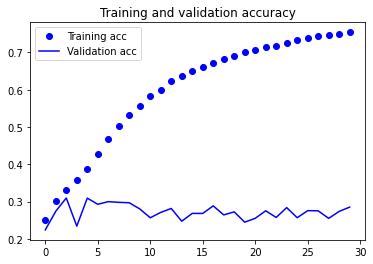

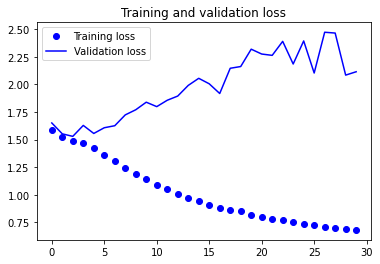

In [93]:
chart(baseline_history)

In [ ]:
# Train the Model


In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores


In [ ]:
# Save the Model
model.save('text_model_1.h5')

### Model #2  (Student Name: XXXX)

In [ ]:
# Build the Model


In [ ]:
# Train the Model


In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores


### Model #3  (Student Name: XXXX)

In [ ]:
# Build the Model


In [ ]:
# Train the Model


In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores


In [ ]:
# Save the Model
model.save('text_model_2.h5')

### Model #4  (Student Name: XXXX)

In [ ]:
# Build the Model


In [ ]:
# Train the Model


In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores


In [ ]:
# Save the Model
model.save('text_model_2.h5')

### Model #5  (Student Name: XXXX)

In [ ]:
# Build the Model


In [ ]:
# Train the Model


In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores


In [ ]:
# Save the Model
model.save('text_model_2.h5')

## Step 3 – Evaluate the Model using Testing Data (Individual & Group)

In [ ]:
# Model #1 (replicate where necessary for other models)
model1 = keras.models.load_model('text_model_1.h5')


In [ ]:
# Model #2 (replicate where necessary for other models)
model2 = keras.models.load_model('text_model_2.h5')


In [ ]:
# Model #3 (replicate where necessary for other models)
model3 = keras.models.load_model('text_model_3.h5')


In [ ]:
# Model #4 (replicate where necessary for other models)
model4 = keras.models.load_model('text_model_4.h5')


In [ ]:
# Model #5 (replicate where necessary for other models)
model5 = keras.models.load_model('text_model_5.h5')


In [ ]:
# Save the Best Model
model.save('text_model_best.h5')

## Step 4 – Use the Best Model to make prediction (Group)

In [ ]:
best_model = keras.models.load_model('text_model_best.h5')

In [ ]:
# takes the user input
text_input = np.array([input()])

In [ ]:
# convert the user input into numeric tensor


In [ ]:
# show the model output using predict function

